In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt

# Hourly Approach

## Import Data

In [284]:
# Electricity generation data
elec_gen_df = pd.read_csv('../data/electricity/elec_gen_hourly_jul_dec_2018.csv', low_memory = False)

# Electricity price data
elec_prc_df = pd.read_csv('../data/electricity/elc_price_hourly_2018_ercot.csv')

## Clean Data

In [285]:
## Fix column names

elec_prc_df.columns = [x.replace(' ', '_').lower() for x in elec_prc_df.columns]

elec_gen_df.columns = [x.replace(' ', '_').replace('(', '').replace(')', '').lower() for x in elec_gen_df.columns]
elec_gen_df.rename(columns = {'hour_number': 'delivery_hour', 'data_date': 'delivery_date'}, inplace = True)

In [286]:
## Subset data

elec_prc_subset_df = elec_prc_df.copy().query(
    'settlement_point_name == "HB_BUSAVG" & delivery_interval == 1 & repeated_hour_flag == "N"')

elec_gen_subset_df = elec_gen_df.copy().query('balancing_authority == "ERCO"')

In [287]:
## Fix numbers: convert to floats

elec_prc_subset_df['settlement_point_price'] = elec_prc_subset_df['settlement_point_price'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)

elec_gen_subset_df['net_generation_mw'] = elec_gen_subset_df['net_generation_mw'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)

elec_gen_subset_df['demand_mw'] = elec_gen_subset_df['demand_mw'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)

## Merge Data

In [288]:
## Merge
elec_gen_prc_df = elec_gen_subset_df.merge(elec_prc_subset_df, on = ['delivery_date', 'delivery_hour'])

## Subset to normal prices and quantities
elec_gen_prc_df = elec_gen_prc_df.query('settlement_point_price > 0 & net_generation_mw > 0')

In [289]:
elec_gen_prc_df.head()

,balancing_authority,delivery_date,delivery_hour,local_time_at_end_of_hour,utc_time_at_end_of_hour,demand_forecast_mw,demand_mw,net_generation_mw,total_interchange_mw,sumvalid_dibas_mw,...,net_generation_mw_from_hydropower_and_pumped_storage,net_generation_mw_from_solar,net_generation_mw_from_wind,net_generation_mw_from_other_fuel_sources,net_generation_mw_from_unknown_fuel_sources,delivery_interval,repeated_hour_flag,settlement_point_name,settlement_point_type,settlement_point_price
1728,ERCO,09/11/2018,1,09/11/2018 1:00:00 AM,09/11/2018 6:00:00 AM,NaN,36104.0,36082.0,-23,-24,...,3,0,"4,800",13,NaN,1,N,HB_BUSAVG,SH,18.62
1729,ERCO,09/11/2018,2,09/11/2018 2:00:00 AM,09/11/2018 7:00:00 AM,NaN,34597.0,34405.0,-192,-193,...,4,0,"4,501",15,NaN,1,N,HB_BUSAVG,SH,17.81
1730,ERCO,09/11/2018,3,09/11/2018 3:00:00 AM,09/11/2018 8:00:00 AM,NaN,33692.0,33363.0,-330,-330,...,5,0,"4,128",11,NaN,1,N,HB_BUSAVG,SH,17.78
1731,ERCO,09/11/2018,4,09/11/2018 4:00:00 AM,09/11/2018 9:00:00 AM,NaN,33341.0,33150.0,-191,-191,...,5,0,"3,895",12,NaN,1,N,HB_BUSAVG,SH,17.62
1732,ERCO,09/11/2018,5,09/11/2018 5:00:00 AM,09/11/2018 10:00:00 AM,NaN,33674.0,33315.0,-359,-359,...,5,0,"4,018",12,NaN,1,N,HB_BUSAVG,SH,17.69


In [8]:
## Pivot dataframe
egp_pivot_df = elec_gen_prc_df.pivot(index = 'delivery_date', 
                                     values = ['net_generation_mw', 'settlement_point_price'], 
                                     columns = 'delivery_hour')

# Flatten hierarchical column names
egp_pivot_df.columns = ['net_gen_' + str(i) for i in range(1,25)] + ['price_' + str(i) for i in range(1,25)]

# Reset index
egp_pivot_df = egp_pivot_df.reset_index()

In [9]:
egp_pivot_df.head()

,delivery_date,net_gen_1,net_gen_2,net_gen_3,net_gen_4,net_gen_5,net_gen_6,net_gen_7,net_gen_8,net_gen_9,...,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24
0,09/11/2018,36082.0,34405.0,33363.0,33150.0,33315.0,35146.0,38747.0,40140.0,40460.0,...,25.20,26.17,26.45,27.74,25.52,24.93,27.70,23.59,20.52,19.04
1,09/12/2018,36894.0,35364.0,34269.0,33823.0,34152.0,36049.0,39598.0,40949.0,41510.0,...,50.50,52.37,73.01,55.44,27.91,39.68,42.47,30.14,23.08,19.65
2,09/13/2018,39176.0,37340.0,36150.0,35512.0,35637.0,37392.0,40771.0,41726.0,42303.0,...,31.01,30.53,32.19,31.48,28.78,28.37,33.78,24.34,20.82,19.81
3,09/14/2018,40008.0,37981.0,36603.0,35708.0,35600.0,37144.0,40379.0,41662.0,42259.0,...,28.69,29.17,28.34,28.81,26.10,27.20,26.47,22.98,20.51,19.53
4,09/15/2018,38600.0,36813.0,35642.0,34891.0,34645.0,35083.0,36061.0,36858.0,39046.0,...,38.74,50.22,31.27,37.58,26.76,27.14,26.03,26.49,21.10,20.78


## Plots

In [22]:
elec_gen_prc_df.head()

,balancing_authority,delivery_date,delivery_hour,local_time_at_end_of_hour,utc_time_at_end_of_hour,demand_forecast_mw,demand_mw,net_generation_mw,total_interchange_mw,sumvalid_dibas_mw,...,net_generation_mw_from_solar,net_generation_mw_from_wind,net_generation_mw_from_other_fuel_sources,net_generation_mw_from_unknown_fuel_sources,delivery_interval,repeated_hour_flag,settlement_point_name,settlement_point_type,settlement_point_price,month
1728,ERCO,09/11/2018,1,09/11/2018 1:00:00 AM,09/11/2018 6:00:00 AM,NaN,36104.0,36082.0,-23,-24,...,0,"4,800",13,NaN,1,N,HB_BUSAVG,SH,18.62,11
1729,ERCO,09/11/2018,2,09/11/2018 2:00:00 AM,09/11/2018 7:00:00 AM,NaN,34597.0,34405.0,-192,-193,...,0,"4,501",15,NaN,1,N,HB_BUSAVG,SH,17.81,11
1730,ERCO,09/11/2018,3,09/11/2018 3:00:00 AM,09/11/2018 8:00:00 AM,NaN,33692.0,33363.0,-330,-330,...,0,"4,128",11,NaN,1,N,HB_BUSAVG,SH,17.78,11
1731,ERCO,09/11/2018,4,09/11/2018 4:00:00 AM,09/11/2018 9:00:00 AM,NaN,33341.0,33150.0,-191,-191,...,0,"3,895",12,NaN,1,N,HB_BUSAVG,SH,17.62,11
1732,ERCO,09/11/2018,5,09/11/2018 5:00:00 AM,09/11/2018 10:00:00 AM,NaN,33674.0,33315.0,-359,-359,...,0,"4,018",12,NaN,1,N,HB_BUSAVG,SH,17.69,11


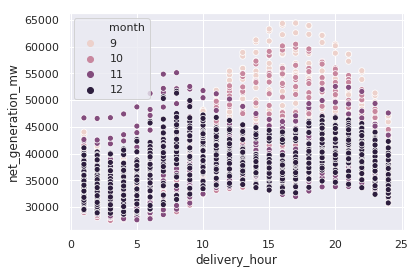

In [27]:
elec_gen_prc_df['month'] = elec_gen_prc_df['delivery_date'].apply(lambda x: int(x[0:2]))
sns.scatterplot(data = elec_gen_prc_df, y = 'net_generation_mw', x = 'delivery_hour', hue = 'month')

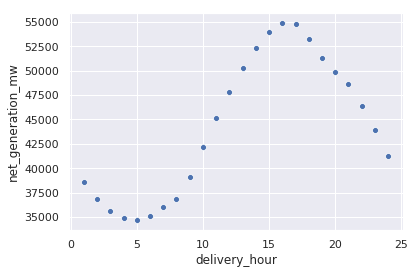

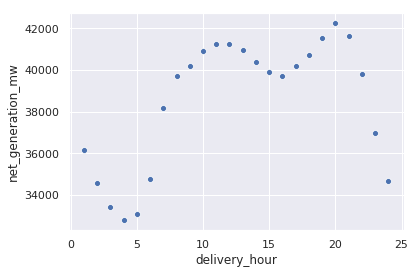

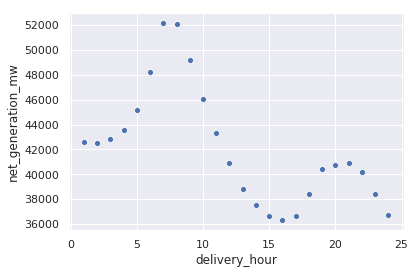

In [31]:
plt.figure()
sns.scatterplot(data = elec_gen_prc_df.query('delivery_date == "09/15/2018"'), y = 'net_generation_mw', x = 'delivery_hour')
plt.figure()
sns.scatterplot(data = elec_gen_prc_df.query('delivery_date == "10/15/2018"'), y = 'net_generation_mw', x = 'delivery_hour')
plt.figure()
sns.scatterplot(data = elec_gen_prc_df.query('delivery_date == "11/15/2018"'), y = 'net_generation_mw', x = 'delivery_hour')

## Regressions

In [10]:
for i in range(1,25):
    
    for j in range(1,25): 
        
        egp_pivot_df['log_net_gen_{0}_{1}'.format(i,j)] = np.log(
            np.divide(egp_pivot_df['net_gen_' + str(i)], egp_pivot_df['net_gen_' + str(j)]))
        
        egp_pivot_df['log_price_{0}_{1}'.format(i,j)]   = np.log(
            np.divide(egp_pivot_df['price_' + str(i)], egp_pivot_df['price_' + str(j)]))

egp_pivot_df['month_idx']   = egp_pivot_df['delivery_date'].apply(lambda x: 'month_' + x[:2])

In [24]:
egp_pivot_df.head()

,delivery_date,net_gen_1,net_gen_2,net_gen_3,net_gen_4,net_gen_5,net_gen_6,net_gen_7,net_gen_8,net_gen_9,...,log_price_24_20,log_net_gen_24_21,log_price_24_21,log_net_gen_24_22,log_price_24_22,log_net_gen_24_23,log_price_24_23,log_net_gen_24_24,log_price_24_24,month_idx
0,09/11/2018,36082.0,34405.0,33363.0,33150.0,33315.0,35146.0,38747.0,40140.0,40460.0,...,-0.269530,-0.167565,-0.374890,-0.140364,-0.214281,-0.070034,-0.074858,0.0,0.0,month_09
1,09/12/2018,36894.0,35364.0,34269.0,33823.0,34152.0,36049.0,39598.0,40949.0,41510.0,...,-0.702770,-0.201820,-0.770721,-0.156617,-0.427776,-0.082534,-0.160889,0.0,0.0,month_09
2,09/13/2018,39176.0,37340.0,36150.0,35512.0,35637.0,37392.0,40771.0,41726.0,42303.0,...,-0.359145,-0.193896,-0.533682,-0.153099,-0.205934,-0.081933,-0.049727,0.0,0.0,month_09
3,09/14/2018,40008.0,37981.0,36603.0,35708.0,35600.0,37144.0,40379.0,41662.0,42259.0,...,-0.331265,-0.153720,-0.304060,-0.120985,-0.162673,-0.065502,-0.048961,0.0,0.0,month_09
4,09/15/2018,38600.0,36813.0,35642.0,34891.0,34645.0,35083.0,36061.0,36858.0,39046.0,...,-0.267018,-0.163486,-0.225259,-0.115401,-0.242776,-0.060904,-0.015282,0.0,0.0,month_09


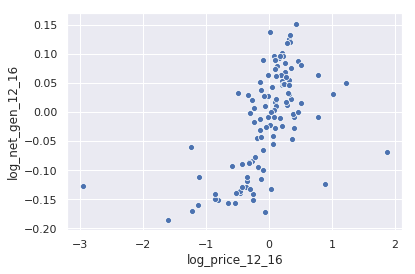

In [25]:
sns.scatterplot(x = 'log_price_12_16', y = 'log_net_gen_12_16', data = egp_pivot_df)

In [26]:
smf.ols('log_net_gen_12_14 ~ log_price_14_12 + month_idx', data = egp_pivot_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_net_gen_12_14   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     49.96
Date:                Thu, 28 Feb 2019   Prob (F-statistic):           1.77e-23
Time:                        12:40:05   Log-Likelihood:                 219.66
No. Observations:                 110   AIC:                            -429.3
Df Residuals:                     105   BIC:                            -415.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0674      0.008     -8.460      0.000      -0.083      -0.052
month_idx[T.month_10]     0.0283      0.010      2.846      0.005       0.009       0.048
month_idx[T.month_11]     0.0879      0.010      8.577      0.000       0.068       0.108
month_idx[T.month_12]     0.1015      0.010      9.862      0.000       0.081       0.122
log_price_14_12          -0.0306      0.009     -3.415      0.001      -0.048      -0.013
==============================================================================
Omnibus:                       12.516   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                4.113
Skew:                           0.032   Prob(JB):                        0.128
Kurtosis:                       2.055   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### All possible (table)

In [27]:
elas_est = np.zeros((12,12))

for i in range(1,13):
    for j in range(1,13):
        
        elas_est[i-1, j-1] = smf.ols('log_net_gen_{0}_{1} ~ log_price_{1}_{0}'.format(i, j), 
                                     data = egp_pivot_df).fit().params[1]

elas_df = pd.DataFrame(elas_est)
elas_df.columns = list(range(1,13))
elas_df.index   = list(range(1,13))
elas_df

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,-0.011369,-0.016225,-0.012098,-0.017516,-0.025291,-0.033189,-0.034110,-0.022910,-0.017812,-0.013209,-0.017631
2,-0.011369,0.000000,-0.003585,-0.005578,-0.004749,-0.014727,-0.027291,-0.028474,-0.015034,-0.011924,-0.007970,-0.017543
3,-0.016225,-0.003585,0.000000,-0.002900,0.003522,-0.007292,-0.030332,-0.071560,-0.049924,-0.029245,-0.015190,-0.042996
4,-0.012098,-0.005578,-0.002900,0.000000,0.001867,0.000826,-0.014099,-0.028621,-0.019155,-0.015439,-0.014594,-0.031519
5,-0.017516,-0.004749,0.003522,0.001867,0.000000,-0.002507,-0.012473,-0.030674,-0.019722,-0.013334,-0.015918,-0.039476
6,-0.025291,-0.014727,-0.007292,0.000826,-0.002507,0.000000,-0.009062,-0.041592,-0.022892,-0.008193,-0.025699,-0.082564
7,-0.033189,-0.027291,-0.030332,-0.014099,-0.012473,-0.009062,0.000000,-0.001107,-0.017064,-0.030691,-0.045745,-0.080170
8,-0.034110,-0.028474,-0.071560,-0.028621,-0.030674,-0.041592,-0.001107,0.000000,-0.034824,-0.047486,-0.077481,-0.116038
9,-0.022910,-0.015034,-0.049924,-0.019155,-0.019722,-0.022892,-0.017064,-0.034824,0.000000,-0.007291,-0.043652,-0.095959
10,-0.017812,-0.011924,-0.029245,-0.015439,-0.013334,-0.008193,-0.030691,-0.047486,-0.007291,0.000000,-0.021711,-0.062417


### Divided by Hour 1 Data

In [109]:
egp_h1_df = elec_gen_prc_df.copy()

In [110]:
# Add hour 1 data for each date
h1_dict = egp_h1_df.query('delivery_hour == 1')[['delivery_date', 'net_generation_mw', 'settlement_point_price']].set_index('delivery_date').to_dict()
egp_h1_df['h1_demand'] = egp_h1_df['delivery_date'].apply(lambda x: h1_dict['net_generation_mw'].get(x))
egp_h1_df['h1_price']  = egp_h1_df['delivery_date'].apply(lambda x: h1_dict['settlement_point_price'].get(x))

In [111]:
# Divide data by respective hour 1 data
egp_h1_df['elc_demand_by_h1'] = np.divide(egp_h1_df['net_generation_mw'],      egp_h1_df['h1_demand'])
egp_h1_df['elc_price_by_h1']  = np.divide(egp_h1_df['settlement_point_price'], egp_h1_df['h1_price'])

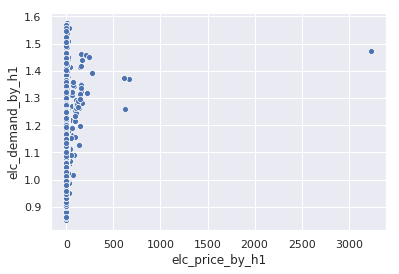

In [112]:
sns.scatterplot(x = 'elc_price_by_h1', y = 'elc_demand_by_h1', data = egp_h1_df)

In [113]:
egp_h1_df.to_csv('../data/processed/egp_h1_eos_est.csv', index = False)

# Monthly Approach

## Import Data

In [219]:
sales_df = pd.read_csv('../data/electricity/retail_sales.csv')
price_df = pd.read_csv('../data/electricity/avg_elec_price.csv')

## Clean Data

In [220]:
# Fix state names
sales_df['State Name'] = sales_df['State Name'].apply(lambda x: x.strip().lower()) 
price_df['State Name'] = price_df['State Name'].apply(lambda x: x.strip().lower()) 

# Melt dataframes
sales_melt_df = pd.melt(sales_df.query('Sector == "All"'), id_vars = ['State Name'],
        value_vars = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                      'August', 'September', 'October', 'November', 'December'],
        var_name   = 'Month',
        value_name = 'elc_demand')

price_melt_df = pd.melt(price_df.query('Sector == " all sectors"'), id_vars = ['State Name'],
        value_vars = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                      'August', 'September', 'October', 'November', 'December'],
        var_name   = 'Month',
        value_name = 'elc_price')

## Merge Data

In [221]:
elc_sales_price_df = sales_melt_df.merge(price_melt_df, on = ['State Name', 'Month'])
elc_sales_price_df.columns = [x.replace(' ', '_').lower() for x in elc_sales_price_df.columns]

elc_sales_price_df.head()

,state_name,month,elc_demand,elc_price
0,connecticut,January,2553,17.18
1,maine,January,1000,12.90
2,massachusetts,January,4662,16.62
3,new hampshire,January,941,15.77
4,rhode island,January,654,16.76


In [222]:
## Pivot dataframe
esp_pivot_df = elc_sales_price_df.pivot(index = 'state_name', 
                                     values = ['elc_demand', 'elc_price'], 
                                     columns = 'month')

# Flatten hierarchical column names
esp_pivot_df.columns = ['elc_demand_' + str(i) for i in range(1,13)] + ['elc_price_' + str(i) for i in range(1,13)]

# Reset index
esp_pivot_df = esp_pivot_df.reset_index()

## Plots

In [506]:
esp_pivot_df.head()

,state_name,elc_demand_1,elc_demand_2,elc_demand_3,elc_demand_4,elc_demand_5,elc_demand_6,elc_demand_7,elc_demand_8,elc_demand_9,...,log_elc_demand_12_8,log_elc_price_12_8,log_elc_demand_12_9,log_elc_price_12_9,log_elc_demand_12_10,log_elc_price_12_10,log_elc_demand_12_11,log_elc_price_12_11,log_elc_demand_12_12,log_elc_price_12_12
0,alabama,6194.0,8866.0,7042.0,6968.0,7688.0,8824.0,8014.0,6437.0,6904.0,...,0.230172,0.090303,0.160133,0.066414,0.249307,0.058932,0.164925,0.015175,0.0,0.0
1,alaska,480.0,494.0,595.0,535.0,577.0,473.0,462.0,527.0,469.0,...,-0.114468,0.023211,0.002130,-0.016098,-0.127663,-0.028140,-0.073804,-0.021590,0.0,0.0
2,arizona,5400.0,8523.0,5537.0,5199.0,5918.0,9120.0,8223.0,5327.0,6260.0,...,0.285756,0.162945,0.124364,0.027550,0.295945,0.153396,0.107102,0.064539,0.0,0.0
3,arkansas,3220.0,4741.0,3609.0,3745.0,3899.0,4826.0,3863.0,3423.0,3291.0,...,0.239429,0.106262,0.278754,0.089648,0.245289,0.093458,0.129957,0.065853,0.0,0.0
4,california,19148.0,27016.0,20757.0,18597.0,20117.0,23900.0,22358.0,20225.0,19390.0,...,0.179020,0.151944,0.221182,0.110730,0.203242,0.107371,0.122175,0.161810,0.0,0.0


## Regressions

In [478]:
for i in range(1,13):
    for j in range(1,13): 
        
        esp_pivot_df['log_elc_demand_{0}_{1}'.format(i,j)] = np.log(
            np.divide(esp_pivot_df['elc_demand_' + str(i)], esp_pivot_df['elc_demand_' + str(j)]))
        
        esp_pivot_df['log_elc_price_{0}_{1}'.format(i,j)]   = np.log(
            np.divide(esp_pivot_df['elc_price_' + str(i)], esp_pivot_df['elc_price_' + str(j)]))


In [479]:
esp_pivot_df.head()

,state_name,elc_demand_1,elc_demand_2,elc_demand_3,elc_demand_4,elc_demand_5,elc_demand_6,elc_demand_7,elc_demand_8,elc_demand_9,...,log_elc_demand_12_8,log_elc_price_12_8,log_elc_demand_12_9,log_elc_price_12_9,log_elc_demand_12_10,log_elc_price_12_10,log_elc_demand_12_11,log_elc_price_12_11,log_elc_demand_12_12,log_elc_price_12_12
0,alabama,6194.0,8866.0,7042.0,6968.0,7688.0,8824.0,8014.0,6437.0,6904.0,...,0.230172,0.090303,0.160133,0.066414,0.249307,0.058932,0.164925,0.015175,0.0,0.0
1,alaska,480.0,494.0,595.0,535.0,577.0,473.0,462.0,527.0,469.0,...,-0.114468,0.023211,0.002130,-0.016098,-0.127663,-0.028140,-0.073804,-0.021590,0.0,0.0
2,arizona,5400.0,8523.0,5537.0,5199.0,5918.0,9120.0,8223.0,5327.0,6260.0,...,0.285756,0.162945,0.124364,0.027550,0.295945,0.153396,0.107102,0.064539,0.0,0.0
3,arkansas,3220.0,4741.0,3609.0,3745.0,3899.0,4826.0,3863.0,3423.0,3291.0,...,0.239429,0.106262,0.278754,0.089648,0.245289,0.093458,0.129957,0.065853,0.0,0.0
4,california,19148.0,27016.0,20757.0,18597.0,20117.0,23900.0,22358.0,20225.0,19390.0,...,0.179020,0.151944,0.221182,0.110730,0.203242,0.107371,0.122175,0.161810,0.0,0.0


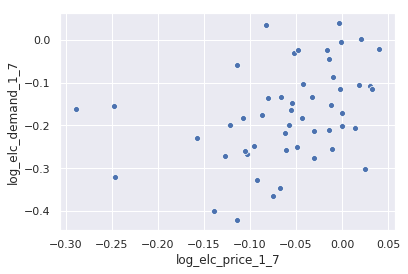

In [508]:
sns.scatterplot(y = 'log_elc_demand_1_7', x = 'log_elc_price_1_7', data = esp_pivot_df)

In [490]:
smf.ols('log_elc_demand_1_5 ~ log_elc_price_1_5', data = esp_pivot_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_elc_demand_1_5   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     8.161
Date:                Wed, 20 Feb 2019   Prob (F-statistic):            0.00626
Time:                        19:01:24   Log-Likelihood:                 68.456
No. Observations:                  51   AIC:                            -132.9
Df Residuals:                      49   BIC:                            -129.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1887      0.009    -20.809      0.000      -0.207      -0.170
log_elc_price_1_5    -0.6455      0.226     -2.857      0.006      -1.100      -0.191
==============================================================================
Omnibus:                        0.948   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.315
Skew:                          -0.071   Prob(JB):                        0.854
Kurtosis:                       3.358   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### All possible (table)

In [500]:
elas_est = np.zeros((12,12))

for i in range(1,13):
    for j in range(1,13):
        
        elas_est[i-1, j-1] = smf.ols('log_elc_demand_{0}_{1} ~ log_elc_price_{1}_{0}'.format(i, j), 
                                     data = esp_pivot_df).fit().params[1]

In [504]:
elas_df = pd.DataFrame(elas_est)
elas_df.columns = list(range(1,13))
elas_df.index   = list(range(1,13))
elas_df

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,-0.279310,0.330965,0.580274,0.645468,-0.396541,-0.577270,0.286498,-0.184672,-0.110066,-0.671133,-0.367258
2,-0.279310,0.000000,-0.457269,-0.411627,-0.243380,-0.183112,0.070929,-0.475383,-0.182110,-0.545769,-0.215407,-0.389292
3,0.330965,-0.457269,0.000000,0.036602,-0.018723,-0.546083,-0.521500,0.145699,0.194360,0.426053,-0.296647,-0.606812
4,0.580274,-0.411627,0.036602,0.000000,0.381313,-0.537144,-0.620107,0.422252,-0.191441,-0.083760,-0.566566,-0.598132
5,0.645468,-0.243380,-0.018723,0.381313,0.000000,-0.394736,-0.401097,0.655242,0.252185,-0.021352,-0.172493,-0.346864
6,-0.396541,-0.183112,-0.546083,-0.537144,-0.394736,0.000000,0.344215,-0.653689,-0.380697,-0.713970,-0.335453,-0.510454
7,-0.577270,0.070929,-0.521500,-0.620107,-0.401097,0.344215,0.000000,-0.801356,-0.532839,-0.801536,-0.463747,-0.709145
8,0.286498,-0.475383,0.145699,0.422252,0.655242,-0.653689,-0.801356,0.000000,-0.388940,-0.021050,-0.714583,-0.640440
9,-0.184672,-0.182110,0.194360,-0.191441,0.252185,-0.380697,-0.532839,-0.388940,0.000000,-0.336541,-0.124559,-0.314875
10,-0.110066,-0.545769,0.426053,-0.083760,-0.021352,-0.713970,-0.801536,-0.021050,-0.336541,0.000000,-0.511980,-0.566437


### Divided by Jan Data

In [534]:
esp_jan_df = elc_sales_price_df.copy()

In [535]:
# Add January data for each state
jan_dict = esp_jan_df.query('month == "January"')[['state_name', 'elc_demand', 'elc_price']].set_index('state_name').to_dict()
esp_jan_df['jan_demand'] = esp_jan_df['state_name'].apply(lambda x: jan_dict['elc_demand'].get(x))
esp_jan_df['jan_price']  = esp_jan_df['state_name'].apply(lambda x: jan_dict['elc_price'].get(x))

In [536]:
# Divide data by respective January data
esp_jan_df['elc_demand_by_jan'] = np.divide(esp_jan_df['elc_demand'], esp_jan_df['jan_demand'])
esp_jan_df['elc_price_by_jan']  = np.divide(esp_jan_df['elc_price'], esp_jan_df['jan_price'])

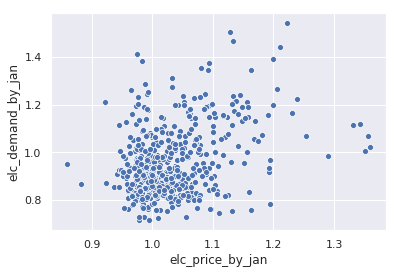

In [537]:
sns.scatterplot(x = 'elc_price_by_jan', y = 'elc_demand_by_jan', data = esp_jan_df)

In [543]:
esp_jan_df.head()

,state_name,month,elc_demand,elc_price,jan_demand,jan_price,elc_demand_by_jan,elc_price_by_jan
0,connecticut,January,2553,17.18,2553,17.18,1.0,1.0
1,maine,January,1000,12.90,1000,12.90,1.0,1.0
2,massachusetts,January,4662,16.62,4662,16.62,1.0,1.0
3,new hampshire,January,941,15.77,941,15.77,1.0,1.0
4,rhode island,January,654,16.76,654,16.76,1.0,1.0


In [555]:
from datetime import datetime as dt
esp_jan_df['month_num'] = esp_jan_df['month'].apply(lambda x: dt.strptime(x,'%B').month)

In [570]:
smf.ols('np.log(elc_demand_by_jan) ~ np.log(np.power(elc_price_by_jan, -1)*np.sin((month_num-1)/11*2*np.pi)+2)', data = esp_jan_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log(elc_demand_by_jan)   R-squared:                       0.088
Model:                                   OLS   Adj. R-squared:                  0.086
Method:                        Least Squares   F-statistic:                     58.77
Date:                       Thu, 21 Feb 2019   Prob (F-statistic):           7.02e-14
Time:                               13:18:39   Log-Likelihood:                 397.93
No. Observations:                        612   AIC:                            -791.9
Df Residuals:                            610   BIC:                            -783.0
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 0.0188      0.011      1.776      0.076      -0.002       0.040
np.log(np.power(elc_price_by_jan, -1) * np.sin((month_num - 1) / 11 * 2 * np.pi) + 2)    -0.1109      0.014     -7.666      0.000      -0.139      -0.083
==============================================================================
Omnibus:                       22.100   Durbin-Watson:                   0.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.660
Skew:                           0.417   Prob(JB):                     4.42e-06
Kurtosis:                       3.520   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [581]:
esp_jan_df.to_csv('../data/processed/esp_jan_eos_est.csv', index = False)

# Ercot Hourly Loads

In [4]:
# Electricity load data
elec_load_df = pd.read_excel('../data/electricity/elc_load_hourly_2018_ercot.xlsx')

# Electricity price data
elec_prc_df  = pd.read_csv('../data/electricity/elc_price_hourly_2018_ercot.csv')

# Weather data
weather_df = pd.read_csv('../data/temperature/TX_AUSTIN_hourly_rainfall_rad_temp_2018.csv')

# Wind data
wind_df = pd.read_csv('../data/wind/wind_austin_tx_2018.csv')

In [5]:
# CLean up electricity load data

elec_load_df         = elec_load_df[['HourEnding', 'COAST']].copy()
elec_load_df.columns = ['datetime', 'load']

elec_load_df['date'] = elec_load_df['datetime'].apply(lambda x: x[:10])
elec_load_df['hour'] = elec_load_df['datetime'].apply(lambda x: int(x[11:13]))

elec_load_df.sample(n=10)

,datetime,load,date,hour
8656,12/27/2018 17:00,10528.159271,12/27/2018,17
21,01/01/2018 22:00,13500.728340,01/01/2018,22
613,01/26/2018 14:00,10327.493798,01/26/2018,14
8340,12/14/2018 13:00,12308.193650,12/14/2018,13
8353,12/15/2018 02:00,10033.358963,12/15/2018,2
2864,04/30/2018 10:00,10996.884796,04/30/2018,10
5869,09/02/2018 15:00,12835.817586,09/02/2018,15
1397,02/28/2018 06:00,9621.040247,02/28/2018,6
367,01/16/2018 08:00,13657.244009,01/16/2018,8
7156,10/26/2018 06:00,8866.330455,10/26/2018,6


In [6]:
# Clean up electricity price data

elec_prc_df.columns = [x.replace(' ', '_').lower() for x in elec_prc_df.columns]

elec_prc_df = elec_prc_df.copy().query(
    'settlement_point_name == "HB_HOUSTON" & delivery_interval == 1 & repeated_hour_flag == "N"')

elec_prc_df['settlement_point_price'] = elec_prc_df['settlement_point_price'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)


elec_prc_df         = elec_prc_df[['delivery_date', 'delivery_hour', 'settlement_point_price']]
elec_prc_df.columns = ['date', 'hour', 'price']

elec_prc_df.sample(n=10)

,date,hour,price
105692,02/20/2018,2,6.27
433140,07/25/2018,4,18.68
747740,12/21/2018,2,28.92
619084,10/21/2018,5,20.49
229596,04/19/2018,19,18.95
566196,09/26/2018,4,19.44
551236,09/19/2018,2,18.62
348044,06/14/2018,21,27.54
170372,03/22/2018,18,20.08
247372,04/28/2018,5,16.72


In [7]:
# Clean up weather data

weather_df.columns = [x.lower() for x in weather_df.columns]

weather_df = weather_df[['lst_date', 'lst_time', 't_hr_avg', 'p_calc', 'solarad']]
weather_df.columns = ['date', 'hour', 'temperature', 'precipitation', 'solar_rad']

weather_df['hour']        = weather_df['hour']/100
weather_df['temperature'] = weather_df['temperature'].apply(lambda x: x if x > -999 else np.nan)
weather_df['precipitation'] = weather_df['precipitation'].apply(lambda x: x if x < 9999 else np.nan)
weather_df['date']        = weather_df['date'].apply(lambda x: '{1}/{2}/{0}'.format(str(x)[:4], str(x)[4:6], str(x)[6:])) 

weather_df.sample(n=5)

,date,hour,temperature,precipitation,solar_rad
787,02/02/2018,14.0,13.9,0.0,645
803,02/03/2018,6.0,6.9,0.0,0
7421,11/06/2018,0.0,18.9,0.0,0
7060,10/21/2018,23.0,13.2,0.0,0
7003,10/19/2018,14.0,14.9,0.9,105


In [8]:
# Format wind data

def format_date(month, day, year):
    
    if int(day) < 10:
        day = '0' + day
    if int(month) < 10:
        month = '0' + month
    
    return '{0}/{1}/{2}'.format(month, day, str(year))

wind_df['date'] =  wind_df['date'].apply(lambda x: format_date(*x.split('/')))

In [9]:
# Merge data
elec_merged_df = elec_prc_df.merge(
    elec_load_df, on = ['date', 'hour']).merge(
    weather_df,   on = ['date', 'hour']).merge(
    wind_df,      on = ['date']).copy()

# Drop duplicates
elec_merged_df = elec_merged_df.groupby(['date', 'hour']).first().reset_index()

In [10]:
elec_merged_df.describe()

,hour,price,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd
count,8389.000000,8389.000000,8389.000000,8384.000000,8328.000000,8389.000000,8389.000000,8389.000000,8389.000000
mean,11.995709,29.875219,12201.935565,19.208469,0.122022,190.368697,-0.452597,-0.080399,1.531703
std,6.631559,54.793145,2721.923364,9.096950,1.473804,273.722529,5.077855,2.036321,4.414750
min,1.000000,-4.810000,7897.150515,-11.000000,0.000000,0.000000,-12.311020,-5.000000,-10.924997
25%,6.000000,18.750000,10299.066421,12.600000,0.000000,0.000000,-4.918588,-1.449999,-1.549999
50%,12.000000,21.370000,11482.902769,20.600000,0.000000,14.000000,-1.592560,-0.225000,2.100002
75%,18.000000,29.020000,13672.507322,25.600000,0.000000,323.000000,3.907126,1.300000,5.125000
max,23.000000,1401.230000,20269.849015,42.100000,94.100000,1078.000000,10.477413,7.050001,10.725000


In [11]:
from datetime import datetime

elec_merged_df['date_fmt'] = elec_merged_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
elec_merged_df['month']    = elec_merged_df['date_fmt'].apply(lambda x: int(x.month))

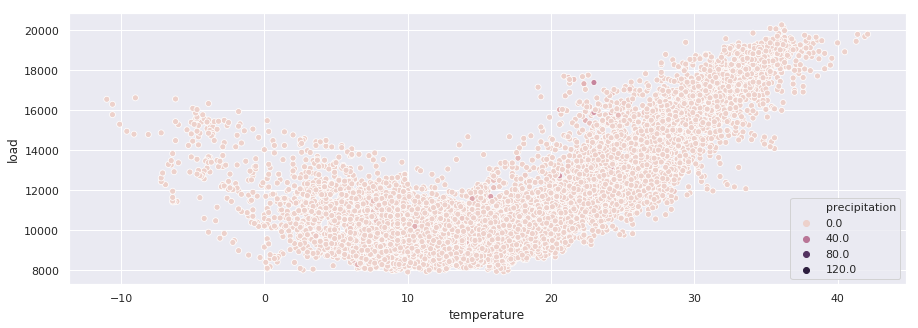

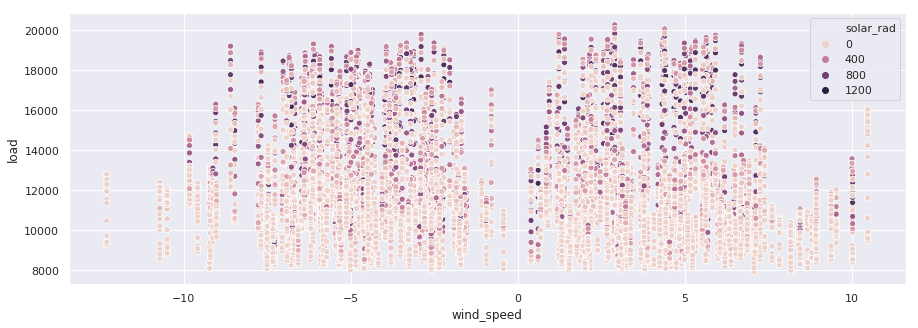

In [12]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'temperature', y = 'load', hue = 'precipitation', data = elec_merged_df)

plt.figure(figsize = (15,5))
sns.scatterplot(x = 'wind_speed', y = 'load', hue = 'solar_rad', data = elec_merged_df)

In [13]:
# Add relative values
elec_merged_df['price_rel'] = elec_merged_df['price']/elec_merged_df.query('date == "02/03/2018" & hour == 1')['price'].values
elec_merged_df['load_rel']  = elec_merged_df['load']/elec_merged_df.query('date == "02/03/2018" & hour == 1')['load'].values

In [14]:
# Add day indices
elec_merged_df['day'] = elec_merged_df['date_fmt'].apply(lambda x: x.timetuple().tm_yday)

In [15]:
elec_merged_df.sample(n=8)

,date,hour,price,datetime,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd,date_fmt,month,price_rel,load_rel,day
2077,04/01/2018,9,17.10,04/01/2018 09:00,8938.063488,18.6,0.0,245,4.903890,0.725000,4.850001,2018-04-01,4,0.930866,0.939014,91
5160,08/13/2018,10,26.32,08/13/2018 10:00,14714.062810,26.9,0.0,490,-3.942240,-0.724999,3.875001,2018-08-13,8,1.432771,1.545829,225
3872,06/18/2018,10,24.46,06/18/2018 10:00,13534.445439,25.2,0.0,307,-5.423099,-5.000000,2.100002,2018-06-18,6,1.331519,1.421900,169
1560,03/09/2018,20,20.47,03/09/2018 20:00,10541.285695,17.8,0.0,0,8.804155,0.975001,8.750001,2018-03-09,3,1.114317,1.107445,68
7930,12/11/2018,20,36.30,12/11/2018 20:00,11771.995833,10.1,0.0,0,4.699204,1.650001,4.400002,2018-12-11,12,1.976048,1.236741,345
7122,11/06/2018,17,152.52,11/06/2018 17:00,15201.460693,24.3,0.0,146,1.741046,-1.474999,-0.924998,2018-11-06,11,8.302667,1.597034,310
797,02/04/2018,16,19.07,02/04/2018 16:00,9657.339601,18.5,0.0,461,1.282817,-1.074998,-0.699998,2018-02-04,2,1.038106,1.014580,35
7390,11/18/2018,9,29.36,11/18/2018 09:00,9097.825905,6.4,0.0,59,-3.800082,2.300001,-3.024999,2018-11-18,11,1.598258,0.955799,322


In [16]:
# Export
elec_merged_df.sort_values(by = ['date_fmt', 'hour']).to_csv('../data/processed/ercot_load_price_2018.csv', index = False)

## All Unique Combinations (Hourly)

In [17]:
samples = int(2e3)

# Subset dataframe for relevant variables
em_sample_df = elec_merged_df[['price', 'load', 'hour', 'date', 'temperature', 'wind_speed', 'solar_rad']].dropna().copy()

# Drop outliers
cut_low, cut_high = em_sample_df['price'].quantile([0.05, 0.95])
em_sample_df = em_sample_df.query('price < @cut_high & price > @cut_low')
cut_low, cut_high = em_sample_df['load'].quantile([0.05, 0.95])
em_sample_df = em_sample_df.query('load < @cut_high & load > @cut_low')

# Create two subsample dataframes
em_sample_df_1 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

# Concat these two sample dfs
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1).copy()

em_concat_df.head()

,price_1,load_1,hour_1,date_1,temperature_1,wind_speed_1,solar_rad_1,price_2,load_2,hour_2,date_2,temperature_2,wind_speed_2,solar_rad_2
0,18.41,11217.445861,7,05/24/2018,21.2,-3.788966,43,22.05,10621.936615,17,01/05/2018,14.0,5.012610,187
1,19.02,11740.770555,2,08/09/2018,25.0,-2.038535,0,17.99,12574.232633,8,05/30/2018,23.6,-5.584410,297
2,21.59,14032.650559,22,05/11/2018,24.1,-9.048378,0,42.49,12461.419399,15,04/28/2018,28.5,0.395284,815
3,28.32,17427.101891,17,09/08/2018,24.2,-2.274999,147,26.07,11068.091386,10,01/26/2018,9.2,6.643842,24
4,31.32,16161.628264,21,08/06/2018,28.5,-4.918588,0,17.18,9936.365336,7,04/30/2018,17.3,-6.909279,12


In [18]:
em_concat_df = em_concat_df.query('price_1 > 0 & load_1 > 0 & price_2 > 0 & load_2 > 0')
em_concat_df['ln_load_rel']  = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel'] = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))

In [19]:
smf.ols('ln_load_rel ~ ln_price_rel', data = em_concat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     452.7
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           1.02e-90
Time:                        23:35:48   Log-Likelihood:                 253.83
No. Observations:                2000   AIC:                            -503.7
Df Residuals:                    1998   BIC:                            -492.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0024      0.005      0.511      0.609      -0.007       0.012
ln_price_rel     0.2798      0.013     21.277      0.000       0.254       0.306
==============================================================================
Omnibus:                       23.714   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.797
Skew:                          -0.133   Prob(JB):                     0.000137
Kurtosis:                       2.621   Cond. No.                         2.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

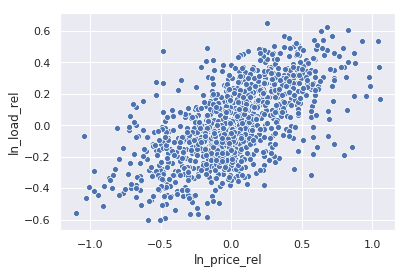

In [26]:
em_concat_df['month_1'] = em_concat_df['date_1'].apply(lambda x: x[:1])
em_concat_df['month_2'] = em_concat_df['date_2'].apply(lambda x: x[:1])
sns.scatterplot(x = 'ln_price_rel', y = 'ln_load_rel', data = em_concat_df.query('month_1 == month_2'))

In [330]:
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman

In [331]:
q = np.array(em_concat_df['ln_load_rel'])
p = np.array(em_concat_df['ln_price_rel'])
t1 = np.array(em_concat_df['temperature_1'])
t2 = np.array(em_concat_df['temperature_2'])
h1 = np.array(em_concat_df['hour_1'])
h2 = np.array(em_concat_df['hour_2'])
z = np.array([t1, t2, h1, h2]).T

ce_q_z, _ = nparam.KernelReg(endog=[q], exog=[z], 
                             reg_type='lc', var_type='cccc', bw=bw_silverman(z)).fit(z)

ce_p_z, _ = nparam.KernelReg(endog=[p], exog=[z], 
                             reg_type='lc', var_type='cccc', bw=bw_silverman(z)).fit(z)

In [332]:
reg_data_df = pd.DataFrame([q, p, ce_q_z, ce_p_z]).T
reg_data_df.columns = ['q', 'p', 'ce_q_z', 'ce_p_tz']
smf.ols('np.add(q, -ce_q_z) ~ np.add(p, -ce_p_z)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_z)   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     218.9
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           4.42e-47
Time:                        22:11:30   Log-Likelihood:                 2931.1
No. Observations:                2000   AIC:                            -5858.
Df Residuals:                    1998   BIC:                            -5847.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0001      0.001      0.112      0.911      -0.002       0.003
np.add(p, -ce_p_z)     0.1324      0.009     14.795      0.000       0.115       0.150
==============================================================================
Omnibus:                       77.645   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.933
Skew:                           0.000   Prob(JB):                     7.14e-51
Kurtosis:                       4.665   Cond. No.                         7.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## All Unique Combinations (Daily)

In [192]:
em_monthly_df = elec_merged_df.groupby(['date'])[
    ['price', 'load', 'temperature', 'wind_speed', 'solar_rad']].mean().reset_index()

In [193]:
samples = int(2e3)

# Subset dataframe for relevant variables

em_sample_df = em_monthly_df.dropna().copy()

# Create two subsample dataframes
em_sample_df_1 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

# Concat these two sample dfs
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1).copy()
em_concat_df.head()

,date_1,price_1,load_1,temperature_1,wind_speed_1,solar_rad_1,date_2,price_2,load_2,temperature_2,wind_speed_2,solar_rad_2
0,05/11/2018,19.631304,7087.289860,24.291304,-9.048378,316.173913,04/11/2018,17.167826,5495.825119,19.330435,-4.399007,297.043478
1,09/08/2018,24.106522,7353.038801,22.917391,-2.274999,103.521739,12/29/2018,26.527826,6861.825612,4.000000,6.054801,53.608696
2,10/01/2018,33.826522,7014.476350,23.543478,-4.465774,163.652174,05/24/2018,25.159130,7928.705047,25.734783,-3.788966,284.217391
3,01/22/2018,18.530870,5695.148529,11.139130,7.071422,189.782609,12/12/2018,34.790435,5934.742740,13.769565,6.329002,72.608696
4,03/07/2018,19.108261,5308.048979,11.213043,-4.602309,256.304348,05/22/2018,25.451304,7438.950785,24.639130,1.817278,271.000000


In [197]:
em_concat_df = em_concat_df.query('price_1 > 0 & load_1 > 0 & price_2 > 0 & load_2 > 0')
em_concat_df['ln_load_rel']  = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel'] = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))

In [198]:
smf.ols('ln_load_rel ~ ln_price_rel', data = em_concat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     432.4
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           4.20e-87
Time:                        21:15:29   Log-Likelihood:                -50.615
No. Observations:                2000   AIC:                             105.2
Df Residuals:                    1998   BIC:                             116.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0078      0.006     -1.413      0.158      -0.019       0.003
ln_price_rel     0.1934      0.009     20.795      0.000       0.175       0.212
==============================================================================
Omnibus:                       34.164   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.517
Skew:                           0.003   Prob(JB):                     5.78e-05
Kurtosis:                       2.516   Cond. No.                         1.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman

In [200]:
q = np.array(em_concat_df['ln_load_rel'])
p = np.array(em_concat_df['ln_price_rel'])
t1 = np.array(em_concat_df['temperature_1'])
t2 = np.array(em_concat_df['temperature_2'])
z = np.array([t1, t2]).T

ce_q_z, _ = nparam.KernelReg(endog=[q], exog=[z], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(z)).fit(z)

ce_p_z, _ = nparam.KernelReg(endog=[p], exog=[z], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(z)).fit(z)

In [201]:
reg_data_df = pd.DataFrame([q, p, ce_q_z, ce_p_z]).T
reg_data_df.columns = ['q', 'p', 'ce_q_z', 'ce_p_tz']
smf.ols('np.add(q, -ce_q_z) ~ np.add(p, -ce_p_z)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_z)   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     60.21
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           1.35e-14
Time:                        21:15:32   Log-Likelihood:                 2184.6
No. Observations:                2000   AIC:                            -4365.
Df Residuals:                    1998   BIC:                            -4354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0004      0.002      0.202      0.840      -0.003       0.004
np.add(p, -ce_p_z)     0.0272      0.004      7.760      0.000       0.020       0.034
==============================================================================
Omnibus:                        2.725   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                2.878
Skew:                           0.017   Prob(JB):                        0.237
Kurtosis:                       3.183   Cond. No.                         1.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## All Unique Combinations (Monthly)

In [209]:
elec_merged_df['month'] = elec_merged_df['date'].apply(lambda x: int(x[0:2]))
em_monthly_df = elec_merged_df.groupby(['month'])[
    ['price', 'load', 'temperature', 'wind_speed', 'solar_rad']].mean().reset_index()

In [210]:
samples = int(2e3)

# Subset dataframe for relevant variables

em_sample_df = em_monthly_df.dropna().copy()

# Create two subsample dataframes
em_sample_df_1 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_1.columns = [x + '_1' for x in em_sample_df_1.columns] 
em_sample_df_2 = em_sample_df.sample(n=samples, replace = True).reset_index(drop=True)
em_sample_df_2.columns = [x + '_2' for x in em_sample_df_2.columns] 

# Concat these two sample dfs
em_concat_df = pd.concat([em_sample_df_1, em_sample_df_2], axis = 1).copy()
em_concat_df.head()

,month_1,price_1,load_1,temperature_1,wind_speed_1,solar_rad_1,month_2,price_2,load_2,temperature_2,wind_speed_2,solar_rad_2
0,11,33.170957,5916.629432,12.219420,1.154364,129.391304,1,30.876087,6649.587091,8.051753,1.610359,127.995792
1,2,22.721491,5999.346606,11.321997,-0.410387,93.380435,11,33.170957,5916.629432,12.219420,1.154364,129.391304
2,4,23.639710,5576.002399,17.901161,-0.183085,235.427536,7,38.224208,8666.924229,29.037447,0.940525,289.008415
3,10,34.349762,6226.241689,18.726788,-0.616806,127.824684,1,30.876087,6649.587091,8.051753,1.610359,127.995792
4,8,34.056971,8792.539775,28.439691,-1.565229,268.234222,12,27.371229,6061.964469,10.074576,-1.022936,105.009887


In [211]:
em_concat_df = em_concat_df.query('price_1 > 0 & load_1 > 0 & price_2 > 0 & load_2 > 0')
em_concat_df['ln_load_rel']  = np.log(np.divide(em_concat_df['load_1'], em_concat_df['load_2']))
em_concat_df['ln_price_rel'] = np.log(np.divide(em_concat_df['price_1'], em_concat_df['price_2']))

In [212]:
smf.ols('ln_load_rel ~ ln_price_rel', data = em_concat_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ln_load_rel   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1387.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):          5.58e-231
Time:                        21:17:21   Log-Likelihood:                 570.78
No. Observations:                2000   AIC:                            -1138.
Df Residuals:                    1998   BIC:                            -1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0051      0.004      1.265      0.206      -0.003       0.013
ln_price_rel     0.5624      0.015     37.239      0.000       0.533       0.592
==============================================================================
Omnibus:                       37.460   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.196
Skew:                          -0.041   Prob(JB):                     2.50e-05
Kurtosis:                       2.502   Cond. No.                         3.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.bandwidths import bw_silverman

In [214]:
q = np.array(em_concat_df['ln_load_rel'])
p = np.array(em_concat_df['ln_price_rel'])
t1 = np.array(em_concat_df['temperature_1'])
t2 = np.array(em_concat_df['temperature_2'])
z = np.array([t1, t2]).T

ce_q_z, _ = nparam.KernelReg(endog=[q], exog=[z], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(z)).fit(z)

ce_p_z, _ = nparam.KernelReg(endog=[p], exog=[z], 
                             reg_type='lc', var_type='cc', bw=bw_silverman(z)).fit(z)

In [215]:
reg_data_df = pd.DataFrame([q, p, ce_q_z, ce_p_z]).T
reg_data_df.columns = ['q', 'p', 'ce_q_z', 'ce_p_tz']
smf.ols('np.add(q, -ce_q_z) ~ np.add(p, -ce_p_z)', data = reg_data_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.add(q, -ce_q_z)   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1651.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):          1.14e-263
Time:                        21:17:25   Log-Likelihood:                 4256.1
No. Observations:                2000   AIC:                            -8508.
Df Residuals:                    1998   BIC:                            -8497.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0002      0.001      0.384      0.701      -0.001       0.002
np.add(p, -ce_p_z)     0.1353      0.003     40.638      0.000       0.129       0.142
==============================================================================
Omnibus:                       62.137   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.750
Skew:                          -0.025   Prob(JB):                     3.47e-07
Kurtosis:                       2.405   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Schwarz et al. Replication
Schwarz, Taylor, Birmingham, Dardan (2002)

In [333]:
em_sample_df = elec_merged_df[['price', 'load', 'hour', 'date', 'temperature', 'wind_speed', 'solar_rad']].dropna().copy()

#em_sample_df = elec_gen_prc_df[['delivery_date', 'delivery_hour', 'net_generation_mw', 'settlement_point_price']].dropna().copy()
#em_sample_df.columns = ['date', 'hour', 'load', 'price']

# Generate time variables
em_sample_df['month'] = em_sample_df['date'].apply(lambda x: int(x[0:2]))
em_sample_df['season'] = em_sample_df['month'].apply(lambda x: int(1+np.floor(x/4)))

# Drop outliers
cut_low, cut_high = em_sample_df['price'].quantile([0.05, 0.95])
em_sample_df = em_sample_df.query('price < @cut_high & price > @cut_low')
cut_low, cut_high = em_sample_df['load'].quantile([0.05, 0.95])
em_sample_df = em_sample_df.query('load < @cut_high & load > @cut_low')

In [334]:
## Variable Generation

# Logged variables
em_sample_df['ln_load']  = np.log(em_sample_df['load'])
em_sample_df['ln_price'] = np.log(em_sample_df['price'])

# Seasonal geometric means of load and price   
em_sample_df['ln_load_gm']  = em_sample_df.groupby(['season'])[['ln_load']].transform('mean')
em_sample_df['ln_price_gm'] = em_sample_df.groupby(['season'])[['ln_price']].transform('mean')

# Daily electricity expenditure
em_sample_df['elc_exp_h'] = np.multiply(em_sample_df['load'], em_sample_df['price'])
em_sample_df['elc_exp_d'] = em_sample_df.groupby(['date'])['elc_exp_h'].transform('sum')

# Expenditure shares
em_sample_df['exp_shr'] = np.divide(em_sample_df['elc_exp_h'], em_sample_df['elc_exp_d'])

# Seasonal arithmetic mean of expenditure shares
em_sample_df['exp_shr_am'] = em_sample_df.groupby(['season'])['exp_shr'].transform('mean')

# Daily price index
em_sample_df['temp'] = np.multiply(np.add(em_sample_df['exp_shr'], em_sample_df['exp_shr_am']), 
                                   np.add(em_sample_df['ln_price'], (-1)*em_sample_df['ln_price_gm']))
em_sample_df['price_idx'] = (1/2)*em_sample_df.groupby(['date'])['temp'].transform('sum')

# For notational simplicity
em_sample_df['E'] = np.divide(em_sample_df['ln_load'], em_sample_df['ln_load_gm'])
em_sample_df['P'] = np.divide(em_sample_df['ln_price'], em_sample_df['ln_price_gm'])
em_sample_df['D'] = em_sample_df['price_idx']

In [335]:
em_sample_df.head()

,price,load,hour,date,temperature,wind_speed,solar_rad,month,season,ln_load,...,ln_price_gm,elc_exp_h,elc_exp_d,exp_shr,exp_shr_am,temp,price_idx,E,P,D
0,27.68,11425.979115,1,01/01/2018,-6.1,5.520471,0,1,1,9.343645,...,3.046341,316271.101903,9.645156e+06,0.032791,0.05559,0.024249,0.525099,1.005386,1.090065,0.525099
1,27.62,11408.418023,2,01/01/2018,-6.3,5.520471,0,1,1,9.342107,...,3.046341,315100.505795,9.645156e+06,0.032669,0.05559,0.024024,0.525099,1.005220,1.089353,0.525099
2,27.43,11405.198365,3,01/01/2018,-6.4,5.520471,0,1,1,9.341825,...,3.046341,312844.591152,9.645156e+06,0.032435,0.05559,0.023353,0.525099,1.005190,1.087087,0.525099
3,27.95,11450.560138,4,01/01/2018,-6.4,5.520471,0,1,1,9.345794,...,3.046341,320043.155857,9.645156e+06,0.033182,0.05559,0.025218,0.525099,1.005617,1.093252,0.525099
4,27.38,11631.337459,5,01/01/2018,-6.4,5.520471,0,1,1,9.361458,...,3.046341,318466.019627,9.645156e+06,0.033018,0.05559,0.023346,0.525099,1.007302,1.086488,0.525099


In [336]:
smf.ols('E ~ np.add(D, -P) + np.multiply(D, -1)', data = em_sample_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      E   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     1332.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:11:36   Log-Likelihood:                 19517.
No. Observations:                6787   AIC:                        -3.903e+04
Df Residuals:                    6784   BIC:                        -3.901e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8702      0.003    337.425      0.000       0.865       0.875
np.add(D, -P)         -0.1306      0.003    -50.284      0.000      -0.136      -0.125
np.multiply(D, -1)    -0.1041      0.002    -48.999      0.000      -0.108      -0.100
==============================================================================
Omnibus:                      111.021   Durbin-Watson:                   0.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.129
Skew:                          -0.318   Prob(JB):                     6.07e-26
Kurtosis:                       3.078   Cond. No.                         34.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""